In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from itertools import product
import numpy as np
import pandas as pd
import warnings
import matplotlib as plt
import seaborn as sns

warnings.filterwarnings("ignore")


## Import Data

In [4]:
serie = pd.read_csv('data/serie_Demanda_Electrica_UE.csv', index_col=0, parse_dates=True)
serie = serie.asfreq('D')
serie.index

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=16802, freq='D')

## Modelos SARIMA(p,0,q)(P,0,Q)m

In [ ]:
def obtener_df_modelos_SARIMA(serie_temp, 
                              p_values:list, 
                              q_values:list, 
                              d=0,
                              P_values:list,
                              Q_values:list,
                              D=0,
                              m):
    
    # Train-test split
    train_size = int(len(serie_temp) * 0.8)
    train, test = serie_temp[:train_size], serie_temp[train_size:]

    # Crear combinaciones de parámetros
    param_combinations = list(product(p_values, q_values, P_values, Q_values))

    # Resultados
    results = []

    # Loop por combinaciones
    for i, (p,q,P,Q) in enumerate(param_combinations):
        try:
            print()
            print(f'Entrenando modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]...')
            model = SARIMAX(train,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, m),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            fitted_model = model.fit(disp=False)  

            # Forecast
            print('Prediciendo...')
            pred = fitted_model.forecast(steps=len(test))

            # Evaluación
            print('Evaluando...')
            aic = fitted_model.aic
            bic = fitted_model.bic
            rmse = np.sqrt(mean_squared_error(test, pred))
            mape = mean_absolute_percentage_error(test, pred)
            r2 = r2_score(test, pred)

            results.append({
                'p': p, 'q': q, #'P': P, 'Q': Q,
                'AIC': aic,
                'BIC': bic,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2
            })

            print(f'Modelo {i+1}/{len(param_combinations)} listo.')

        except Exception as e:
            print(f'Error en modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]: {e} de tipo {type(e).__name__}')
            continue

    # Convertir a DataFrame y ordenar por AIC
    df_arima = pd.DataFrame(results).sort_values('AIC')
    return df_arima

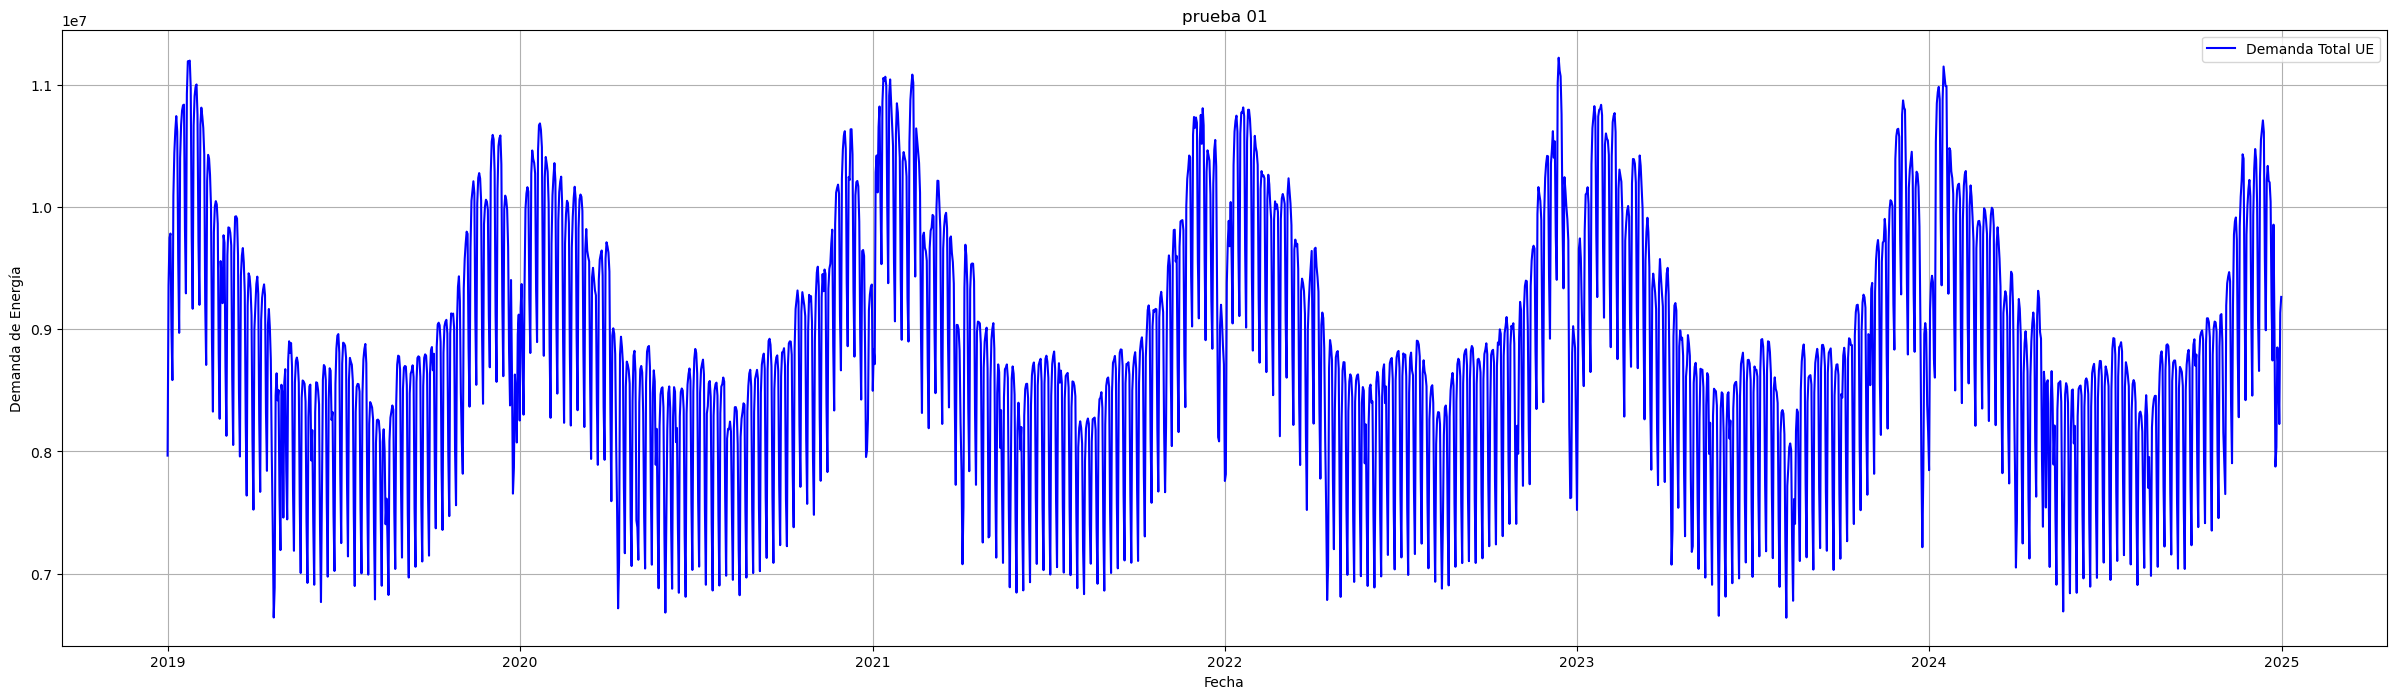

In [ ]:


# Recorte opcional: usar los últimos 6 años para acelerar (ej. 2019-2024)
serie_ej_01 = serie['2019':'2024']

# Crear la figura y el gráfico
plt.figure(figsize=(30, 8))
plt.plot(serie_ej_01.index, serie_ej_01.values, label="Demanda Total UE", color="blue")

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.title("prueba 01")
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

## 1) Hyperparameter Tuning

In [8]:
# Train-test split
train_size_01 = int(len(serie_ej_01) * 0.8)
train_01, test_01 = serie_ej_01[:train_size_01], serie_ej_01[train_size_01:]

# Parámetros a probar: comenzamos con p=1, q=7, y sin P ni Q
p_values = [1, 8]  
q_values = [7]  
d = 0  # La serie es estacionaria
m = 364  # Estacionalidad anual (364 días)

# Crear combinaciones de parámetros
param_combinations = list(product(p_values, q_values))

# Resultados
results = []

# Loop por combinaciones
for i, (p, q) in enumerate(param_combinations):
    P=1
    Q=1
    D=0
    try:
        print()
        print(f'Entrenando modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]...')
        model = SARIMAX(train_01,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted_model = model.fit(disp=False, maxiter=30)  # Menos iteraciones para acelerar

        # Forecast
        print('Prediciendo...')
        pred = fitted_model.forecast(steps=len(test_01))

        # Evaluación
        print('Evaluando...')
        aic = fitted_model.aic
        bic = fitted_model.bic
        rmse = np.sqrt(mean_squared_error(test_01, pred))
        mape = mean_absolute_percentage_error(test_01, pred)

        results.append({
            'p': p, 'q': q, 'P': P, 'Q': Q,
            'AIC': aic,
            'BIC': bic,
            'RMSE': rmse,
            'MAPE': mape
        })

        print(f'Modelo {i+1}/{len(param_combinations)} listo: SARIMA({p},{d},{q})({P},{D},{Q})[{m}]')

    except Exception as e:
        print(f'Error en modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]: {e} de tipo {type(e).__name__}')
        continue

# Convertir a DataFrame y ordenar por AIC
df_sarima_01 = pd.DataFrame(results).sort_values('AIC')


Entrenando modelo SARIMA(1,0,7)(1,0,1)[364]...


KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from itertools import product
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Recorte opcional: usar los últimos años para acelerar (ej. últimos 6 años)
serie_ej_01 = serie['2019':'2024']

# Train-test split
train_size_01 = int(len(serie_ej_01) * 0.8)
train_01, test_01 = serie_ej_01[:train_size_01], serie_ej_01[train_size_01:]

# Parámetros a probar
p_values = [1, 6, 8]
q_values = [7, 14]
P_values = [1]
Q_values = [1, 2]
d = 0
D = 0
m = 364

# Crear combinaciones
param_combinations = list(product(p_values, q_values, P_values, Q_values))

# Resultados
results = []

# Loop por combinaciones
for i, (p, q, P, Q) in enumerate(param_combinations):
    try:
        print()
        print(f'Entrenando modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]...')
        model = SARIMAX(train_01,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted_model = model.fit(disp=False, maxiter=50)

        # Forecast
        print('Prediciendo...')
        pred = fitted_model.forecast(steps=len(test_01))

        # Evaluación
        print('Evaluando...')
        aic = fitted_model.aic
        bic = fitted_model.bic
        rmse = np.sqrt(mean_squared_error(test_01, pred))
        mape = mean_absolute_percentage_error(test_01, pred)
        

        results.append({
            'p': p, 'q': q, 'P': P, 'Q': Q,
            'AIC': aic,
            'BIC': bic,
            'RMSE': rmse,
            'MAPE': mape            
        })

        print(f'Modelo {i+1}/{len(param_combinations)} listo: SARIMA({p},{d},{q})({P},{D},{Q})[{m}]')

    except Exception as e:
        print(f'Error en modelo SARIMA({p},{d},{q})({P},{D},{Q})[{m}]: {e} de tipo {type(e).__name__}')
        continue

# Convertir a DataFrame y ordenar por MAPE
df_sarima_01 = pd.DataFrame(results).sort_values('AIC')


Entrenando modelo SARIMA(1,0,7)(1,0,1)[364]...


KeyboardInterrupt: 

In [6]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(serie) * 0.8)
train, test = serie.iloc[:train_size], serie.iloc[train_size:]

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ranges for p, d, q parameters
d = 0  # stationary series
p = q = range(0, 3)

# Create a list of all possible combinations of p, d, q values
pdq = list(itertools.product(p, d, q))

# Define the seasonal parameter combinations (P, D, Q, s)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming seasonality of 12 months
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [5]:
# Lists to store parameters and AIC values
list_param = []
list_param_seasonal = []
list_results_aic = []

# Variables to track the best model
best_aic = float("inf")  # Start with an infinitely large AIC value
best_param = None
best_param_seasonal = None

In [ ]:
# Loop over each combination of pdq and seasonal_pdq
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit the SARIMA model with the specified parameters
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()

            # Save the parameter combination and its AIC
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
            
            # Print the current combination and its AIC
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Update the best model if the current one has a lower AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal
        except:
            # If the model fails to fit, skip this combination
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:468484.4059576094
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:458419.90695472027
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:455844.13264927466
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:412018.9922702602


In [ ]:
# Print the best model parameters
print("\nBest Model:")
print('ARIMA{}x{}12 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))